# Импортирование основных библиотек

In [49]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt 
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Загрузка данных

In [50]:
df_train_mcc_cat = pd.read_csv('/content/gdrive/MyDrive/DataBase.csv')
df_train_mcc_cat = df_train_mcc_cat.iloc[:618974]
# remove none mcc_name
df_train_mcc_cat = df_train_mcc_cat.dropna(subset=['mcc_name'])
df_train_mcc_cat.shape

(618942, 19)

# EDA (разведочный анализ) и подготовка данных 
## Data preprocessing и перекодировка данных из категориальных в количественные значения, устранение несбалансированности классов

In [51]:
columns = df_train_mcc_cat.columns
columns

Index(['amount', 'atm_address', 'atm_address_lat', 'atm_address_lon', 'city',
       'country', 'currency', 'customer_id', 'home_add_lat', 'home_add_lon',
       'mcc', 'pos_address', 'pos_adress_lat', 'pos_adress_lon', 'terminal_id',
       'transaction_date', 'work_add_lat', 'work_add_lon', 'mcc_name'],
      dtype='object')

In [52]:
df_train_mcc_cat['mcc_name'].value_counts()

Продажа продуктов                               282737
Рестораны                                       123291
Заправки                                         29546
Медицинские товары                               27347
Одежда, обувь и аксессуары - средний сегмент     19150
                                                 ...  
Охранные агенства                                    4
Прокат автомобилей                                   2
Дома на колесах, прицепы                             1
Ритуальные услуги                                    1
Хостинг, ТВ                                          1
Name: mcc_name, Length: 80, dtype: int64

In [53]:
dict_null = {}
for col in columns:
    val = df_train_mcc_cat[col].isna().sum()
    dict_null[col] = val

In [54]:
df_null = pd.DataFrame.from_dict(dict_null, orient='index')
df_null = df_null.sort_values(by=[0], ascending=False)
df_null = df_null.rename(columns={0:'Null counts'})
df_null

,Null counts
atm_address_lat,618942
atm_address_lon,618942
atm_address,618942
work_add_lon,282416
work_add_lat,282416
pos_address,11672
city,13
amount,0
pos_adress_lat,0
transaction_date,0


In [55]:
# change labels in mcc_name by 0 or 1 - label encoding because we intrested in Рестораны category for predictions
df_train_mcc_cat['mcc_name'] = df_train_mcc_cat['mcc_name'].apply(lambda x: 1 if 'Рестораны' in str(x) else 0)
df_train_mcc_cat.sample(10)

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_adress_lat,pos_adress_lon,terminal_id,transaction_date,work_add_lat,work_add_lon,mcc_name
267119,3.587495,NaN,NaN,NaN,DOROKHOVO,RUS,643.0,64dbadca7650d09057c23489a5f91b4b,55.795,37.782,5411,1 1-YA SOVETSKAYA STRDOROKHOVO143000 RUSRUS,55.553054,36.375519,18cf4804a443caa2f1371a7209a7e3e2,2017-07-01,55.744,37.630,0
178455,1.833878,NaN,NaN,NaN,MOSCOW,RUS,643.0,8fb58292c61f94b14a6d2a57cab856ba,55.803,37.578,5999,24 PETROVSKO-RAZUMOVSKIY PASMOSCOW101000 RU...,55.800308,37.565537,8696cc945a06d288c29e1705536359d7,2017-09-17,55.741,37.641,0
569152,2.511802,NaN,NaN,NaN,SANKT-PETERBU,RUS,643.0,8f0c9fd85dea919ae0effae5e932e4c8,59.958,30.219,5812,"4-26, KARAVANNAYASANKT-PETERBU190000 RUSRUS""",59.935633,30.341351,05e74bb21d7aeacfc1cd60a32f8e6196,2017-07-28,59.934,30.324,1
196035,2.958345,NaN,NaN,NaN,SANKT-PETERBU,RUS,643.0,ce50d40b5885b8f80916e079564b1e1d,59.907,30.454,8099,": BELYSHEVA-A, BELYSHEVASANKT-PETERBU193318 ...",59.807053,30.317130,b375c6b73ac95ee4f0dccc489af6c827,2017-10-10,59.925,30.304,0
208645,3.021161,NaN,NaN,NaN,MOSKVA,RUS,643.0,2cf86b00cacc867b6ab71a0c562a2ce1,55.434,37.773,5814,"MIRA PR-T UL.,119/547MOSKVA 129223 RU...",55.733840,37.593096,fc77681330592d5004f6c45f73a3e4bc,2017-06-12,55.655,37.637,1
287826,2.089265,NaN,NaN,NaN,KAPOTNYA,RUS,643.0,ab250daad4112eccbec44ede032ff180,55.639,37.795,5411,3 4-Y KVARTALKAPOTNYA141000 RUSRUS,55.634847,37.801372,c4ba2aaa8285c6782a2a8476d37a3482,2017-07-28,NaN,NaN,0
385524,2.665386,NaN,NaN,NaN,BALASHIKHA,RUS,643.0,e87927fa235edbfa7931095308742b06,55.819,37.965,5411,4 SPORTIVNAYA STRBALASHIKHA143900 RUSRUS,55.815549,37.967168,73942730bec109b98ffc95ed5fe4345d,2017-05-07,55.664,37.537,0
449565,2.830759,NaN,NaN,NaN,SANKT-PETERBU,RUS,643.0,0812e5fa3f08393f09f68a482cbdb430,59.833,30.424,5411,158 BUKHARESTSKAYA STRSANKT-PETERBU190000 R...,59.829152,30.424529,f3b46d79fb24c9ea003e3dbb5c67c3df,2017-06-26,59.849,30.480,0
52012,4.190038,NaN,NaN,NaN,MOSCOW,RUS,643.0,65da3282a3b2264c88bc861cffa476a3,55.795,37.617,5999,33 VARSHAVSKOE SH BLD 12MOSCOW117105 RUSRUS,55.835728,37.621769,f1a65af67080c72589a0abb55c8a9a96,2017-05-13,55.774,37.549,0
565438,2.041728,NaN,NaN,NaN,MOSKVA,RUS,643.0,8dae56c555d14b89841f94ae931830ce,55.713,37.768,5814,"RUSAKOVSKAYA UL., 26MOSKVA 107014 RUSRUS",55.789266,37.681813,b819d4784afa646c72e7771951628e3e,2017-09-17,NaN,NaN,1


0    495651
1    123291
Name: mcc_name, dtype: int64


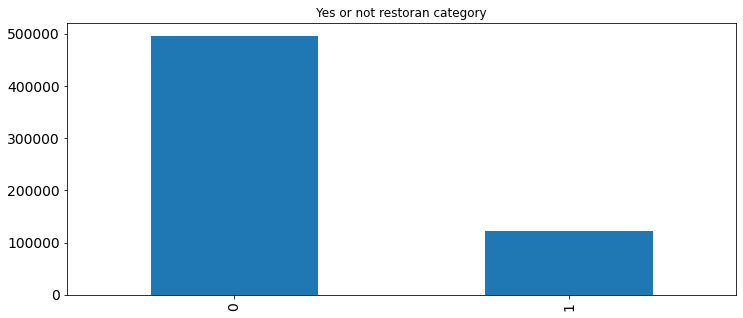

In [56]:
print(df_train_mcc_cat['mcc_name'].value_counts())
f, ax = plt.subplots(figsize=(15, 5))
df_train_mcc_cat['mcc_name'].value_counts().plot(kind='bar', figsize=(12, 5), fontsize=14, title='Yes or not restoran category', ax = ax)

In [57]:
# need to be in equal name
# we see that destribution of city is so width and it's very hard to preprocessing text of city in normal format
df_train_mcc_cat['city'] = df_train_mcc_cat['city'].apply(lambda x: str(x).lower().strip())
print(df_train_mcc_cat['city'].nunique())
city_names = df_train_mcc_cat['city'].value_counts()
print(city_names)
df_city = pd.DataFrame(city_names)
df_city = df_city.reset_index()
df_city = df_city.sort_values(by=['index'],ascending=True)
df_city = df_city.T
df_city

3354
moscow           177503
sankt-peterbu     95751
moskva            59880
ekaterinburg      13017
st petersburg     12260
                  ...  
novgorod obl          1
maima                 1
sotnikovo             1
s.tankovoe            1
moskva,p.kiev         1
Name: city, Length: 3354, dtype: int64


,389,460,1988,3233,2580,1383,2380,3169,2512,2897,2859,3286,705,1922,2605,2114,2721,2075,979,1402,1109,3125,1319,1283,1090,2759,2137,944,1274,2758,573,2770,2844,1004,2604,2640,3077,1557,1153,3127,452,574,781,577,362,1039,2144,531,2199,1853,736,2916,2710,2618,367,1249,2870,222,714,2871,1529,490,2163,1211,934,1355,496,2141,895,2404,616,2210,3270,2255,2339,3091,1446,977,3013,1864,1704,826,925,38,325,1217,2785,546,1812,374,494,1019,3341,1272,1438,441,2201,2733,1813,204,1607,295,2782,2603,1874,2893,342,897,3011,2125,468,2082,1237,1843,3219,2594,3182,2606,3110,1628,1568,1372,3175,1685,1522,2145,274,1901,923,3090,2743,1338,982,2750,789,2846,2256,480,417,1683,3283,1925,3116,2786,3149,262,3293,1117,166,1071,1527,997,3062,185,1194,61,2960,834,2215,1491,3201,3042,2263,928,1995,1785,624,2558,100,2388,1227,338,3264,738,2687,194,3124,1650,1155,2000,1911,1150,2789,3126,2146,54,2560,1671,2573,1243,3199,363,1868,1397,2915,1606,3112,1091,2418,1433,1819,1680,2662,1492,908,2015,1717,1166,2876,285,1225,2047,2182,281,2167,1324,1029,3251,1981,2196,520,1634,2308,76,3194,860,1949,3213,992,1157,829,392,1132,1764,1742,2520,2516,2460,2160,2166,388,1146,783,1690,2976,1104,719,819,2184,2709,...,2038,1490,2212,2290,321,1103,1948,560,2569,108,2235,2220,380,748,1326,2683,846,1057,147,2987,921,1841,620,2377,248,22,1943,2487,1642,1436,2631,2557,961,1473,2115,1719,607,1265,1580,1342,608,226,1156,708,3268,3269,3295,1616,663,2849,1242,1025,2443,308,39,890,1648,3088,339,721,1821,3263,918,1729,2276,854,1002,146,2204,2659,2619,1732,688,528,2688,241,2168,744,2681,381,1067,1672,1107,2447,571,1979,1576,2394,2883,2996,887,2877,1385,1050,2363,596,2140,423,69,3186,958,3240,3312,2927,2980,3281,795,687,3146,3279,1526,2868,2118,2896,35,3179,699,3034,2098,238,1777,1702,1565,709,552,2635,3122,764,485,3252,509,1850,2121,2181,206,143,1515,1290,1159,2567,3048,2396,3151,823,1630,297,3033,2694,1629,1865,3101,1887,2107,368,2179,2108,2251,3131,2192,1434,2457,1198,2111,3020,1945,818,1391,2977,629,2045,1746,2731,2690,1591,833,567,3057,1405,3228,2540,3006,568,730,3317,1875,945,2663,1392,3093,3026,411,316,82,1597,404,935,3280,214,2699,1413,315,328,2068,3294,1102,1623,2482,2247,57,1287,2642,63,701,1723,2656,1598,1113,3204,1398,2006,2005,2452,442,864,1195,1013,740,87,584,3022,1964,2834,472,3087,831,372,286,735,963,3216,850,1064,2521,659,999,3196,189,856,1032,2080
index,",",.,"105, ivana go",108 km minsko,117209,12 km baykals,127562,"136,5 km avto",1375+300 km a,154 km a/d vo,155 km a/d m-,155 km ad mos,21 km kaluzhs,"23, 1, opolch",24+500 km a-d,306+300 km a-,311 km a/d vo,"33, 3, isakov",33-y km yaros,416 km a/d mo,77 - moscow,"89 km,kievsko",abakan,abatskoe,abinsk,abinsk region,abrau dyurso,abrau-dyurso,achinsk,adle,adler,"adler, pos. k",adygeja,adygeya,adygeya resp,adygeysk,adyigeya,aeroport,aeroport domo,aeroport voro,afanasovo,afipskiy,afonino,agalatovo,agalatovskoe,agapovka,agoy,agrogorod,agroles,agronom,akberdino,akhatyrskiy,akhlebino,akhtubinsk,aksai,aksaiy s.,aksaj,aksay,akseno-butyrs,aksubaevo,aktash,alabino,alabushevo,alabushevo so,alapaevsk,aleksandro-ne,aleksandrov,aleksandrovsk,alekseevka,alekseevskoe,aleksin,alenino,alexandrov,aleysk,alfimovo,alkino-2,almetevsk,almetyevsk,alnashi,altaiyskiiy r,altun,alupka,alushta,anapa,anapskaya,anapskiiy reg,anastasievska,andreevka,andreykovo,angarsk,anichkovo,aniskino,annenki,annino,anosino,antipino,antonovka,antsiferovo,apatity,aprelevka,apsheronsk,aramil,aramil',argayash,arhangelsk,arhipovo-osip,arkhangelsk,arkhangelskoe,arkhipo-osipo,armanikha,armavir,arshan,arsk,artem,artemovskiy,arti,artybash,artyom,arzamas,asha,ashitkovo,ashukino,askino,aslana,astrahan,astrahan',astrakhan,atemar,ateptsevo,aul novaja ad,avangard,avazbakeeva,avdotino,avsjunino,avsyunino,avtopoligon,avtozapravoch,axay,azov,b. samovets,babarykino,babyninskiy p,bagrationovsk,bakunino,balaba,balabanovo,balabanovo-1,balahna,balakhna,balakhta,balakirevo,balakovo,balashicha,balashiha,balashika,balashikha,balashikha mk,"balashikha, m","balashikha,d.","balashikha,kv","balashikha

In [58]:
print('Unique users - ', df_train_mcc_cat['customer_id'].nunique())
print('Unique terminal id', df_train_mcc_cat['terminal_id'].nunique())
print('Unique pos_address', df_train_mcc_cat['pos_address'].nunique())
print('Unique currency', df_train_mcc_cat['currency'].nunique())
print('Unique transaction_date', df_train_mcc_cat['transaction_date'].nunique())

Unique users -  6504
Unique terminal id 147814
Unique pos_address 71940
Unique currency 3
Unique transaction_date 214


In [59]:
# prepare data in format month - year
df_train_mcc_cat['transaction_date'] = df_train_mcc_cat['transaction_date'].apply(lambda x: '-'.join(x.split('-')[:2]))
df_train_mcc_cat['transaction_date'].unique().tolist()

['2017-07', '2017-10', '2017-09', '2017-08', '2017-05', '2017-06', '2017-04']

In [60]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
# Implement one hot encoding for date
df_train_mcc_cat_ = df_train_mcc_cat.copy()
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['transaction_date'])
df_train_mcc_cat_ = encoder.fit_transform(df_train_mcc_cat_)
df_train_mcc_cat_.head()

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_adress_lat,pos_adress_lon,terminal_id,transaction_date_0,transaction_date_1,transaction_date_2,work_add_lat,work_add_lon,mcc_name
0,2.884034,NaN,NaN,NaN,st petersburg,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,11606fde0c814ce78e0d726e39a0a5ee,0,0,1,59.847,30.177,0
1,2.775633,NaN,NaN,NaN,st petersburg,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,e9647a5e1eacfb06713b6af755ccc595,0,1,0,59.847,30.177,0
2,3.708368,NaN,NaN,NaN,st petersburg,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5992,"PR.MARSHALA ZHUKOVA,31St Petersburg190000 7...",59.858198,30.229024,df06c1fcd3718a514535ae822785f716,0,1,0,59.847,30.177,0
3,2.787498,NaN,NaN,NaN,st petersburg,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,6c5e5793ebc984fb72875feffff62854,0,1,1,59.847,30.177,0
4,2.892510,NaN,NaN,NaN,st petersburg,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,0576445d74e374c92c0902e612fca356,0,0,1,59.847,30.177,0


We see that russian the most counts county. So we choose only russia for one hot encoding. Counts Russian label -  618942


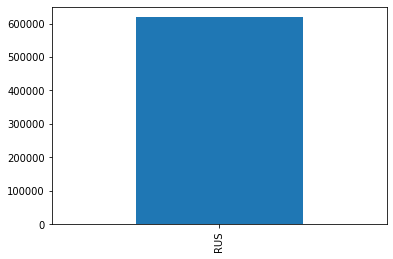

In [62]:
# we see that most frequency country is Russia
# so that we implement label encoding as Russia or nor Russia
df_train_mcc_cat_['country'].value_counts()[:3].plot(kind='bar')
print('We see that russian the most counts county. So we choose only russia for one hot encoding. Counts Russian label - ', df_train_mcc_cat_['country'].value_counts()[0])



In [63]:
# RUS and RU is thr same country: we rename RU as RUS
df_train_mcc_cat_['country'] = df_train_mcc_cat_['country'].apply(lambda x: 'RUS' if 'RU' in x else x)
print('We see that russian the most counts county. So we choose only russia for one hot encoding. Counts Russian label - ', df_train_mcc_cat_['country'].value_counts()[0])



We see that russian the most counts county. So we choose only russia for one hot encoding. Counts Russian label -  618942


In [64]:
# label encoding
df_train_mcc_cat_['country'] = df_train_mcc_cat_['country'].apply(lambda x: 1 if 'RUS' in str(x) else 0)
df_train_mcc_cat_

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_adress_lat,pos_adress_lon,terminal_id,transaction_date_0,transaction_date_1,transaction_date_2,work_add_lat,work_add_lon,mcc_name
0,2.884034,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,11606fde0c814ce78e0d726e39a0a5ee,0,0,1,59.847,30.177,0
1,2.775633,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,e9647a5e1eacfb06713b6af755ccc595,0,1,0,59.847,30.177,0
2,3.708368,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5992,"PR.MARSHALA ZHUKOVA,31St Petersburg190000 7...",59.858198,30.229024,df06c1fcd3718a514535ae822785f716,0,1,0,59.847,30.177,0
3,2.787498,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,6c5e5793ebc984fb72875feffff62854,0,1,1,59.847,30.177,0
4,2.892510,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,0576445d74e374c92c0902e612fca356,0,0,1,59.847,30.177,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618969,2.708481,NaN,NaN,NaN,moskva,1,643.0,50a6f38f900c73d48061195ed53677d8,55.054,38.851,5814,"LENINGRADSKOE SH., 63/1MOSKVA 125445 ...",56.013577,37.208718,ad5d1e8a13786aaad14d0f006c77457c,1,1,0,55.767,37.401,1
618970,2.501882,NaN,NaN,NaN,moskva,1,643.0,50a6f38f900c73d48061195ed53677d8,55.054,38.851,5814,"UL. KRYLATSKAJA, D. 17, KORP. 3MOSKVA121614 ...",55.770719,37.421130,9ee7b946f8cde3475ef63ce72cb5d0dd,0,1,1,55.772,37.425,1
618971,2.501882,NaN,NaN,NaN,moskva,1,643.0,50a6f38f900c73d48061195ed53677d8,55.054,38.851,5814,"UL. KRYLATSKAJA, D. 17, KORP. 3MOSKVA121614 ...",55.770719,37.421130,9ee7b946f8cde3475ef63ce72cb5d0dd,0,1,1,55.767,37.401,1
618972,2.486906,NaN,NaN,NaN,moskva,1,643.0,50a6f38f900c73d48061195ed53677d8,55.054,38.851,5814,"UL. KRYLATSKAJA, D. 17, KORP. 3MOSKVA121614 ...",55.770719,37.421130,fe1933560e179bb2ad36f27a04207890,1,1,0,55.772,37.425,1


In [65]:
df_train_mcc_cat_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618942 entries, 0 to 618973
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   amount              618942 non-null  float64
 1   atm_address         0 non-null       float64
 2   atm_address_lat     0 non-null       float64
 3   atm_address_lon     0 non-null       float64
 4   city                618942 non-null  object 
 5   country             618942 non-null  int64  
 6   currency            618942 non-null  float64
 7   customer_id         618942 non-null  object 
 8   home_add_lat        618942 non-null  float64
 9   home_add_lon        618942 non-null  float64
 10  mcc                 618942 non-null  int64  
 11  pos_address         607270 non-null  object 
 12  pos_adress_lat      618942 non-null  float64
 13  pos_adress_lon      618942 non-null  float64
 14  terminal_id         618942 non-null  object 
 15  transaction_date_0  618942 non-nul

In [66]:
# we see that carruncy no null caruncy
# and the most frequency currency are 643.0, 978, 840.0 
# perform one hot encoding for convert these data in 0 or 1 format
print('Null currency - ', df_train_mcc_cat_['currency'].isna().sum())
print('Counts distributions for currency label \n', df_train_mcc_cat_['currency'].value_counts())
df_train_mcc_cat_['currency_1'] = df_train_mcc_cat_['currency'].apply(lambda x: 1 if x == 643.0 else 0)
df_train_mcc_cat_['currency_2'] = df_train_mcc_cat_['currency'].apply(lambda x: 1 if x == 978.0 else 0)
df_train_mcc_cat_['currency_3'] = df_train_mcc_cat_['currency'].apply(lambda x: 1 if x == 840.0 else 0)
df_train_mcc_cat_.head()

Null currency -  0
Counts distributions for currency label 
 643.0    618928
978.0        13
784.0         1
Name: currency, dtype: int64


,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_adress_lat,pos_adress_lon,terminal_id,transaction_date_0,transaction_date_1,transaction_date_2,work_add_lat,work_add_lon,mcc_name,currency_1,currency_2,currency_3
0,2.884034,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,11606fde0c814ce78e0d726e39a0a5ee,0,0,1,59.847,30.177,0,1,0,0
1,2.775633,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,e9647a5e1eacfb06713b6af755ccc595,0,1,0,59.847,30.177,0,1,0,0
2,3.708368,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5992,"PR.MARSHALA ZHUKOVA,31St Petersburg190000 7...",59.858198,30.229024,df06c1fcd3718a514535ae822785f716,0,1,0,59.847,30.177,0,1,0,0
3,2.787498,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,6c5e5793ebc984fb72875feffff62854,0,1,1,59.847,30.177,0,1,0,0
4,2.892510,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,0576445d74e374c92c0902e612fca356,0,0,1,59.847,30.177,0,1,0,0


In [67]:
df_train_mcc_cat_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618942 entries, 0 to 618973
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   amount              618942 non-null  float64
 1   atm_address         0 non-null       float64
 2   atm_address_lat     0 non-null       float64
 3   atm_address_lon     0 non-null       float64
 4   city                618942 non-null  object 
 5   country             618942 non-null  int64  
 6   currency            618942 non-null  float64
 7   customer_id         618942 non-null  object 
 8   home_add_lat        618942 non-null  float64
 9   home_add_lon        618942 non-null  float64
 10  mcc                 618942 non-null  int64  
 11  pos_address         607270 non-null  object 
 12  pos_adress_lat      618942 non-null  float64
 13  pos_adress_lon      618942 non-null  float64
 14  terminal_id         618942 non-null  object 
 15  transaction_date_0  618942 non-nul

In [68]:
print('pos_adress_lat', df_train_mcc_cat_['pos_adress_lat'].nunique())
print('pos_adress_lon', df_train_mcc_cat_['pos_adress_lon'].nunique())
print('work_add_lat', df_train_mcc_cat_['work_add_lat'].nunique())
print('work_add_lon', df_train_mcc_cat_['work_add_lon'].nunique())

pos_adress_lat 46204
pos_adress_lon 46228
work_add_lat 1488
work_add_lon 1689


Тепловая карта

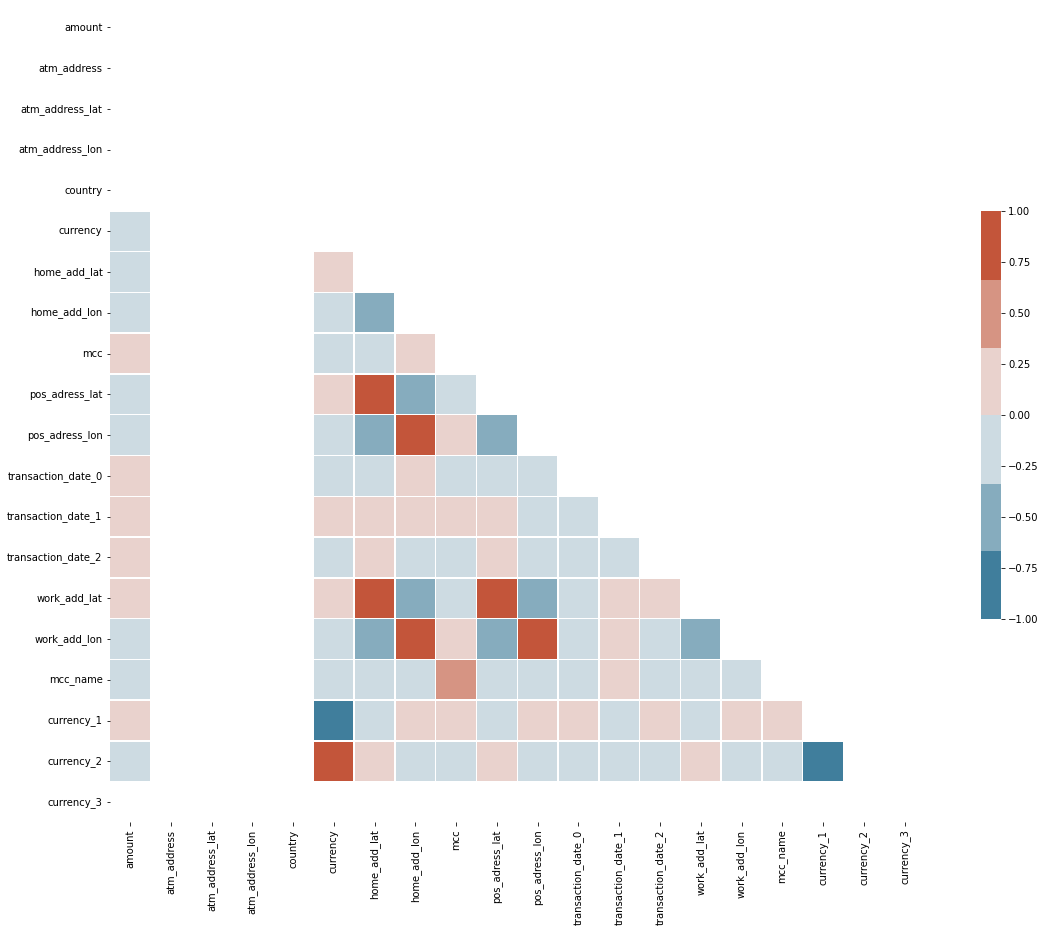

In [120]:
import seaborn as sns
f, ax = plt.subplots(figsize=(20, 15))
mat = df_train_mcc_cat_.corr('spearman') # DataFrame correlations
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=False)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

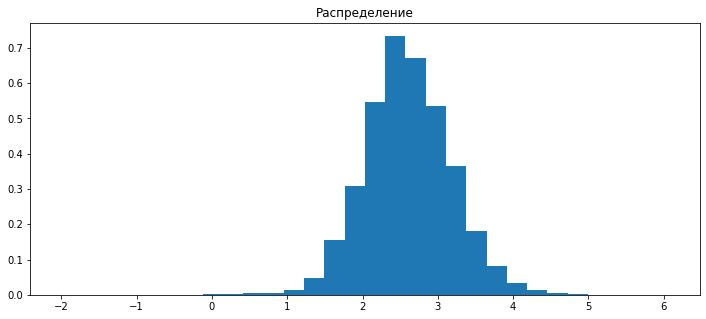

p-value 0.0 -----> Sample Data distribution is not normal


In [69]:
"""
Sample Data distribution is not normal p-value < 0.05
Good article about data normalization https://towardsdatascience.com/data-normalization-in-machine-learning-395fdec69d02
"""

sample_means_control = df_train_mcc_cat_['amount'].values
plt.figure(figsize=(12, 5))
count, bins, ignored = plt.hist(sample_means_control, 30, density=True) # density=True # normed=False
plt.title(f'Распределение')
plt.show()
p = stats.shapiro(sample_means_control).pvalue
print('p-value', p, '-----> Sample Data distribution is not normal')

In [70]:
from sklearn import preprocessing
"""
data normalization
"""
df_train_mcc_cat_['amount'] = preprocessing.scale(df_train_mcc_cat_['amount'])
df_train_mcc_cat_.head()

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_adress_lat,pos_adress_lon,terminal_id,transaction_date_0,transaction_date_1,transaction_date_2,work_add_lat,work_add_lon,mcc_name,currency_1,currency_2,currency_3
0,0.482823,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,11606fde0c814ce78e0d726e39a0a5ee,0,0,1,59.847,30.177,0,1,0,0
1,0.293479,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,e9647a5e1eacfb06713b6af755ccc595,0,1,0,59.847,30.177,0,1,0,0
2,1.922690,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5992,"PR.MARSHALA ZHUKOVA,31St Petersburg190000 7...",59.858198,30.229024,df06c1fcd3718a514535ae822785f716,0,1,0,59.847,30.177,0,1,0,0
3,0.314203,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,6c5e5793ebc984fb72875feffff62854,0,1,1,59.847,30.177,0,1,0,0
4,0.497628,NaN,NaN,NaN,st petersburg,1,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,0576445d74e374c92c0902e612fca356,0,0,1,59.847,30.177,0,1,0,0


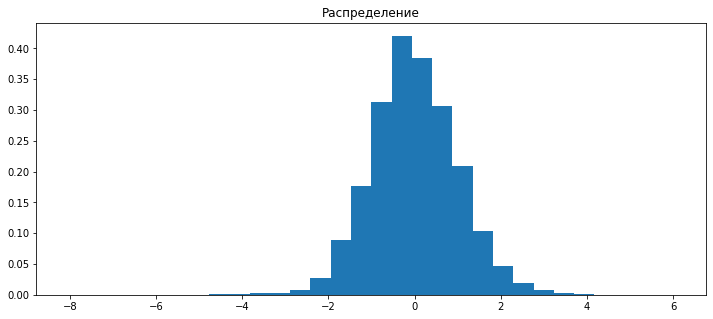

p-value 0.0 -----> Sample Data distribution is not normal


In [71]:
sample_means_control = list(df_train_mcc_cat_['amount'].values)
plt.figure(figsize=(12, 5))
count, bins, ignored = plt.hist(sample_means_control, 30, density=True) # density=True # normed=False
plt.title(f'Распределение')
plt.show()
p = stats.shapiro(sample_means_control).pvalue
if p > 0.05:
    print('p-value', p, '-----> Sample Data distribution is normal')
else:
    print('p-value', p, '-----> Sample Data distribution is not normal')

In [72]:
# Inizialise dataframe 
# We analyse dataset and suppose that geograpic places are not avilable for ML model
df_to_ML = df_train_mcc_cat_[['amount', 'pos_adress_lon', 'pos_adress_lat', 'country', 'transaction_date_0', 'transaction_date_1', 'transaction_date_2', 'mcc_name', 'currency_1', 'currency_2', 'currency_3']]
df_to_ML.head()

,amount,pos_adress_lon,pos_adress_lat,country,transaction_date_0,transaction_date_1,transaction_date_2,mcc_name,currency_1,currency_2,currency_3
0,0.482823,30.179153,59.844072,1,0,0,1,0,1,0,0
1,0.293479,30.179153,59.844072,1,0,1,0,0,1,0,0
2,1.922690,30.229024,59.858198,1,0,1,0,0,1,0,0
3,0.314203,30.179153,59.844072,1,0,1,1,0,1,0,0
4,0.497628,30.179153,59.844072,1,0,0,1,0,1,0,0


In [73]:
# Null counts
df_to_ML.isnull().sum()

amount                0
pos_adress_lon        0
pos_adress_lat        0
country               0
transaction_date_0    0
transaction_date_1    0
transaction_date_2    0
mcc_name              0
currency_1            0
currency_2            0
currency_3            0
dtype: int64

In [74]:
# Fill null elements by mean count of columns
# USE IF IN DATAFRAME EXIST GEOGRAPIC DATA ELSE NOT USEFUL WITH NOT NULL ELEMENTS IN DATASET 
cols_replace_null = ['pos_adress_lon', 'pos_adress_lat']
for col in df_to_ML.columns:
    df_to_ML[col] = df_to_ML[col].replace(np.nan, df_to_ML[col].mean())

In [75]:
df_to_ML.isnull().sum()

amount                0
pos_adress_lon        0
pos_adress_lat        0
country               0
transaction_date_0    0
transaction_date_1    0
transaction_date_2    0
mcc_name              0
currency_1            0
currency_2            0
currency_3            0
dtype: int64

In [76]:
# logistic transformations of dataframe
def log_trans(data):
    for col in data:
        if col == 'mcc_name':
            continue
        else:
            skew = data[col].skew()
            if skew > 0.5 or skew < -0.5:
                data[col] = np.log1p(data[col])
            else:
                continue      
    return data
data_norm = log_trans(df_to_ML)
data_norm

,amount,pos_adress_lon,pos_adress_lat,country,transaction_date_0,transaction_date_1,transaction_date_2,mcc_name,currency_1,currency_2,currency_3
0,0.482823,3.439750,4.108314,1,0,0,1,0,0.693147,0.0,0
1,0.293479,3.439750,4.108314,1,0,1,0,0,0.693147,0.0,0
2,1.922690,3.441348,4.108547,1,0,1,0,0,0.693147,0.0,0
3,0.314203,3.439750,4.108314,1,0,1,1,0,0.693147,0.0,0
4,0.497628,3.439750,4.108314,1,0,0,1,0,0.693147,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
618969,0.176185,3.643064,4.043289,1,1,1,0,1,0.693147,0.0,0
618970,-0.184683,3.648608,4.039021,1,0,1,1,1,0.693147,0.0,0
618971,-0.184683,3.648608,4.039021,1,0,1,1,1,0.693147,0.0,0
618972,-0.210841,3.648608,4.039021,1,1,1,0,1,0.693147,0.0,0


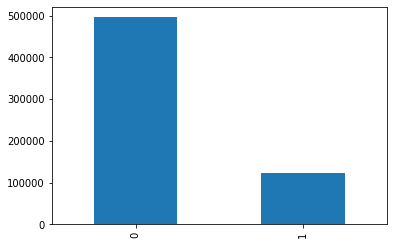

In [77]:
data_norm['mcc_name'].value_counts().plot(kind='bar')

In [78]:
from imblearn.over_sampling import SMOTE

In [79]:
cols = list(df_to_ML.columns)
cols.remove("mcc_name")

In [80]:
"""
We see inbalanced classes in our sample data
Use SMOT for reduce inbalance classes
"""
# X Test dataframe 
df_trial_final = data_norm[cols]
# Y test dataframe
labels = data_norm['mcc_name']
print('Shape of labels - ', labels.shape)
print('Shape of head dataset - ', df_trial_final.shape)
df_trial_final.head()

Shape of labels -  (618942,)
Shape of head dataset -  (618942, 10)


,amount,pos_adress_lon,pos_adress_lat,country,transaction_date_0,transaction_date_1,transaction_date_2,currency_1,currency_2,currency_3
0,0.482823,3.439750,4.108314,1,0,0,1,0.693147,0.0,0
1,0.293479,3.439750,4.108314,1,0,1,0,0.693147,0.0,0
2,1.922690,3.441348,4.108547,1,0,1,0,0.693147,0.0,0
3,0.314203,3.439750,4.108314,1,0,1,1,0.693147,0.0,0
4,0.497628,3.439750,4.108314,1,0,0,1,0.693147,0.0,0


In [81]:
from collections import Counter

In [82]:
"""
Example of SMOTE
but we will not use this variables so that SMOTE implement in the next step in ML model fitting
"""
smote = SMOTE(sampling_strategy='minority')

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(df_trial_final, labels)

print('Original dataset shape', Counter(labels))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 495651, 1: 123291})
Resample dataset shape Counter({0: 495651, 1: 495651})


In [83]:
len(x_smote)

991302

In [84]:
len(y_smote)

991302

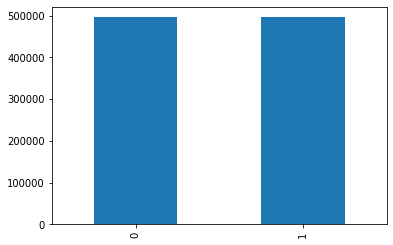

In [85]:
y_smote.value_counts().plot(kind='bar')

In [86]:
# Devide dataset in test and train
X_raw,X_test,y_raw,y_test  = train_test_split(df_trial_final,
                                              labels,
                                              test_size=0.3,
                                              stratify = labels,
                                              random_state = 42)

# AutoGluon


In [9]:
!pip install autogluon 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.4/210.4 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 13.5 MB/s eta 0:00:00
  Using cached boto3-1.26.8-py3-none-any.whl (132 kB)
  Using cached dask-2021.11.2-py3-none-any.whl (1.0 MB)
  Using cached distributed-2021.11.2-py3-none-any.whl (802 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 MB 14.7 MB/s eta 0:00:00
  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
  Using cached psutil-5.

In [91]:
#Оставляем в датасете 95% данных для дальнейшего моделирования
data_norm_pc = data_norm.sample(frac=0.95,random_state=1)
#Выделяем 5% данных для предсказаний
data_norm_pc_us = data_norm.drop(data_norm_pc.index)
#Обновляем индексы
data_norm_pc.reset_index(inplace=True, drop=True)
data_norm_pc_us.reset_index(inplace=True, drop=True)
#Проверяем разбиение
print('Исходные данные: ' + str(data_norm.shape))
print('Данные для моделирования: ' + str(data_norm_pc.shape))
print('Данные для предсказаний: ' + str(data_norm_pc_us.shape))
#wine_pc.to_csv('wine_pc.csv')
#wine_pc_us.to_csv('wine_pc_us.csv')
data_norm_pc.head(2)

Исходные данные: (618942, 11)
Данные для моделирования: (587995, 11)
Данные для предсказаний: (30947, 11)


,amount,pos_adress_lon,pos_adress_lat,country,transaction_date_0,transaction_date_1,transaction_date_2,mcc_name,currency_1,currency_2,currency_3
0,0.034937,3.449476,4.108261,1,1,0,0,0,0.693147,0.0,0
1,-1.039424,3.445394,4.109957,1,1,1,1,0,0.693147,0.0,0


In [92]:
from autogluon.tabular import TabularDataset, TabularPredictor
label = 'mcc_name'
print("Summary of class variable: \n", data_norm_pc[label].describe())

Summary of class variable: 
 count    587995.000000
mean          0.199325
std           0.399493
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: mcc_name, dtype: float64


In [93]:
save_path = 'agModels-predictClass'  # specifies folder to store trained models
predictor = TabularPredictor(label=label, path=save_path).fit(data_norm_pc)

INFO:autogluon.tabular.predictor.predictor:Warning: Training may take a very long time because `time_limit` was not specified and `train_data` is large (587995 samples, 51.74 MB).
INFO:autogluon.tabular.predictor.predictor:	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
INFO:autogluon.tabular.learner.default_learner:Beginning AutoGluon training ...
INFO:autogluon.tabular.learner.default_learner:AutoGluon will save models to "agModels-predictClass/"
INFO:autogluon.tabular.learner.default_learner:AutoGluon Version:  0.5.2
INFO:autogluon.tabular.learner.default_learner:Python Version:     3.7.15
INFO:autogluon.tabular.learner.default_learner:Operating System:   Linux
INFO:autogluon.tabular.learner.default_learner:Train Data Rows:    587995
INFO:autogluon.tabular.learner.default_learner:Train Data Columns: 10
INFO:autogluon.tabular.le

[1000]	valid_set's binary_error: 0.132653
[2000]	valid_set's binary_error: 0.122109
[3000]	valid_set's binary_error: 0.117007
[4000]	valid_set's binary_error: 0.112415
[5000]	valid_set's binary_error: 0.111054
[6000]	valid_set's binary_error: 0.110204
[7000]	valid_set's binary_error: 0.109694
[8000]	valid_set's binary_error: 0.109694
[9000]	valid_set's binary_error: 0.108163
[10000]	valid_set's binary_error: 0.106633


INFO:autogluon.core.trainer.abstract_trainer:	0.8934	 = Validation score   (accuracy)
INFO:autogluon.core.trainer.abstract_trainer:	368.67s	 = Training   runtime
INFO:autogluon.core.trainer.abstract_trainer:	6.91s	 = Validation runtime
INFO:autogluon.core.trainer.abstract_trainer:Fitting model: RandomForestGini ...
INFO:autogluon.core.trainer.abstract_trainer:	0.8578	 = Validation score   (accuracy)
INFO:autogluon.core.trainer.abstract_trainer:	272.23s	 = Training   runtime
INFO:autogluon.core.trainer.abstract_trainer:	0.52s	 = Validation runtime
INFO:autogluon.core.trainer.abstract_trainer:Fitting model: RandomForestEntr ...
INFO:autogluon.core.trainer.abstract_trainer:	0.8503	 = Validation score   (accuracy)
INFO:autogluon.core.trainer.abstract_trainer:	348.97s	 = Training   runtime
INFO:autogluon.core.trainer.abstract_trainer:	0.52s	 = Validation runtime
INFO:autogluon.core.trainer.abstract_trainer:Fitting model: CatBoost ...
INFO:autogluon.core.trainer.abstract_trainer:	0.8162	 = V

[1000]	valid_set's binary_error: 0.121429
[2000]	valid_set's binary_error: 0.111395
[3000]	valid_set's binary_error: 0.108844
[4000]	valid_set's binary_error: 0.106973
[5000]	valid_set's binary_error: 0.106293
[6000]	valid_set's binary_error: 0.105442
[7000]	valid_set's binary_error: 0.104762
[8000]	valid_set's binary_error: 0.103741
[9000]	valid_set's binary_error: 0.103401
[10000]	valid_set's binary_error: 0.103912


INFO:autogluon.core.trainer.abstract_trainer:	0.8978	 = Validation score   (accuracy)
INFO:autogluon.core.trainer.abstract_trainer:	367.57s	 = Training   runtime
INFO:autogluon.core.trainer.abstract_trainer:	7.59s	 = Validation runtime
INFO:autogluon.core.trainer.abstract_trainer:Fitting model: WeightedEnsemble_L2 ...
INFO:autogluon.core.trainer.abstract_trainer:	0.9024	 = Validation score   (accuracy)
INFO:autogluon.core.trainer.abstract_trainer:	3.08s	 = Training   runtime
INFO:autogluon.core.trainer.abstract_trainer:	0.01s	 = Validation runtime
INFO:autogluon.tabular.learner.default_learner:AutoGluon training complete, total runtime = 6655.6s ... Best model: "WeightedEnsemble_L2"
INFO:autogluon.tabular.predictor.predictor:TabularPredictor saved. To load, use: predictor = TabularPredictor.load("agModels-predictClass/")


In [103]:
y_test = data_norm_pc_us[['mcc_name']]  # values to predict
# delete label column to prove we're not cheating

test_data_nolab = data_norm_pc_us.drop(columns=['mcc_name'])  
test_data_nolab.head()

,amount,pos_adress_lon,pos_adress_lat,country,transaction_date_0,transaction_date_1,transaction_date_2,currency_1,currency_2,currency_3
0,-1.191492,4.429062,4.024756,1,1,1,0,0.693147,0.0,0
1,-0.252746,3.649231,4.040869,1,0,1,1,0.693147,0.0,0
2,-0.043257,3.649231,4.040869,1,0,1,0,0.693147,0.0,0
3,-0.030752,3.648306,4.041274,1,1,0,0,0.693147,0.0,0
4,-0.065914,3.649231,4.040869,1,1,0,0,0.693147,0.0,0


In [116]:
#predictor = TabularPredictor.load(save_path) 
y_pred = predictor.predict(test_data_nolab)

In [108]:
perf = predictor.evaluate_predictions(y_true=y_test['mcc_name'], y_pred=y_pred, auxiliary_metrics=True)

INFO:autogluon.tabular.learner.abstract_learner:Evaluation: accuracy on test data: 0.8967266617119591
INFO:autogluon.tabular.learner.abstract_learner:Evaluations on test data:
INFO:autogluon.tabular.learner.abstract_learner:{
    "accuracy": 0.8967266617119591,
    "balanced_accuracy": 0.7791002310102826,
    "mcc": 0.6458068919516753,
    "f1": 0.6903700833171866,
    "precision": 0.8417198204583038,
    "recall": 0.5851535555920513
}


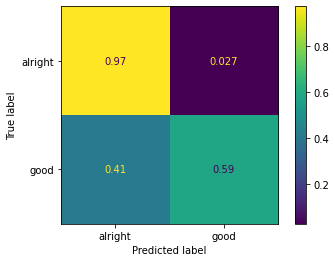

In [109]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
agcm=confusion_matrix(y_test, y_pred,normalize='true')
dispag = ConfusionMatrixDisplay(agcm, display_labels=['alright','good','great'])
dispag.plot()

In [110]:
predictor.leaderboard(data_norm_pc_us)

                  model  score_test  score_val  pred_time_test  pred_time_val     fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2    0.896727   0.902381       75.665172      15.345961  1161.166965                 0.019027                0.010487           3.082266            2       True         14
1         LightGBMLarge    0.896048   0.897789       44.271517       7.588141   367.571347                44.271517                7.588141         367.571347            1       True         13
2              LightGBM    0.892558   0.893367       26.161796       6.905597   368.674904                26.161796                6.905597         368.674904            1       True          4
3               XGBoost    0.890490   0.893537        3.567820       0.622831   420.771041                 3.567820                0.622831         420.771041            1       True         11
4      RandomForestGini    0.8

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.896727,0.902381,75.665172,15.345961,1161.166965,0.019027,0.010487,3.082266,2,True,14
1,LightGBMLarge,0.896048,0.897789,44.271517,7.588141,367.571347,44.271517,7.588141,367.571347,1,True,13
2,LightGBM,0.892558,0.893367,26.161796,6.905597,368.674904,26.161796,6.905597,368.674904,1,True,4
3,XGBoost,0.890490,0.893537,3.567820,0.622831,420.771041,3.567820,0.622831,420.771041,1,True,11
4,RandomForestGini,0.855398,0.857823,6.049841,0.520936,272.230884,6.049841,0.520936,272.230884,1,True,5
5,RandomForestEntr,0.844993,0.850340,6.439788,0.515396,348.967243,6.439788,0.515396,348.967243,1,True,6
6,NeuralNetTorch,0.832488,0.841667,0.279842,0.077650,3972.872640,0.279842,0.077650,3972.872640,1,True,12
7,CatBoost,0.813261,0.816156,0.017297,0.023199,7.183978,0.017297,0.023199,7.183978,1,True,7
8,NeuralNetFastAI,0.805571,0.805272,0.501357,0.096266,540.003871,0.501357,0.096266,540.003871,1,True,10
9,ExtraTreesGini,0.804828,0.805272,7.311953,0.514728,146.574460,7.311953,0.514728,146.574460,1,True,8


In [111]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.902381      15.345961  1161.166965                0.010487           3.082266            2       True         14
1         LightGBMLarge   0.897789       7.588141   367.571347                7.588141         367.571347            1       True         13
2               XGBoost   0.893537       0.622831   420.771041                0.622831         420.771041            1       True         11
3              LightGBM   0.893367       6.905597   368.674904                6.905597         368.674904            1       True          4
4      RandomForestGini   0.857823       0.520936   272.230884                0.520936         272.230884            1       True          5
5      RandomForestEntr   0.850340       0.515396   348.967243                0.515396      

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestGini': 'RFModel',
  'RandomForestEntr': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesGini': 'XTModel',
  'ExtraTreesEntr': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': 0.8039115646258503,
  'KNeighborsDist': 0.8112244897959183,
  'LightGBMXT': 0.8006802721088435,
  'LightGBM': 0.8933673469387755,
  'RandomForestGini': 0.8578231292517007,
  'RandomForestEntr': 0.8503401360544217,
  'CatBoost': 0.816156462585034,
  'ExtraTreesGini': 0.8052721088435374,
  'ExtraTreesEntr': 0.8030612244897959,
  'NeuralNetFastAI': 0.8052721088435374,
  'XGBoost': 0.8935374149659864,
  'NeuralNetTorch': 0.8416666666666667,
  'LightGBMLarge': 0

In [112]:
i = 4  # index of model to use
model_to_use = predictor.get_model_names()[i]
model_pred = predictor.predict(data_norm_pc_us, model=model_to_use)
print("Prediction from %s model: %s" % (model_to_use, model_pred.iloc[0]))

Prediction from RandomForestGini model: 0


In [113]:
all_models = predictor.get_model_names()
model_to_use = all_models [i]
specific_model = predictor._trainer.load_model(model_to_use)

# Objects defined below are dicts of various information (not printed here as they are quite large):
model_info = specific_model.get_info()
predictor_information = predictor.info()

In [114]:
predictor_information

{'path': 'agModels-predictClass/',
 'label': 'mcc_name',
 'random_state': 0,
 'version': '0.5.2',
 'features': ['amount',
  'pos_adress_lon',
  'pos_adress_lat',
  'transaction_date_0',
  'transaction_date_1',
  'transaction_date_2',
  'currency_1',
  'currency_2'],
 'feature_metadata_in': <autogluon.common.features.feature_metadata.FeatureMetadata at 0x7fc757f57210>,
 'time_fit_preprocessing': 1.455456256866455,
 'time_fit_training': 6654.144483804703,
 'time_fit_total': 6655.599940061569,
 'time_limit': None,
 'time_train_start': 1668425465.400436,
 'num_rows_train': 587995,
 'num_cols_train': 8,
 'num_classes': 2,
 'problem_type': 'binary',
 'eval_metric': 'accuracy',
 'best_model': 'WeightedEnsemble_L2',
 'best_model_score_val': 0.9023809523809524,
 'best_model_stack_level': 2,
 'num_models_trained': 14,
 'num_bag_folds': 0,
 'max_stack_level': 2,
 'max_core_stack_level': 1,
 'model_info': {'KNeighborsUnif': {'name': 'KNeighborsUnif',
   'model_type': 'KNNModel',
   'problem_type':

# ML model импортирование библиотек

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import sklearn
import xgboost as xgb
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from imblearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score


from sklearn.linear_model import SGDClassifier

ModuleNotFoundError: ignored

#  Применение StratifiedKFold for dataset

In [ ]:
sss = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for train_index, test_index in sss.split(X_raw,y_raw):
    
    print("Train:", train_index, "Test:", test_index)
    X_train_sm, X_val_sm = X_raw.iloc[train_index], X_raw.iloc[test_index]
    y_train_sm, y_val_sm = y_raw.iloc[train_index], y_raw.iloc[test_index]

# Check the Distribution of the labels
# Turn into an array
X_train_sm = X_train_sm.values
X_val_sm = X_val_sm.values
y_train_sm = y_train_sm.values
y_val_sm = y_val_sm.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(y_train_sm, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_val_sm, return_counts=True)
print('-' * 84)
print('Label Distributions: \n')
print(train_counts_label/ len(y_train_sm))
print(test_counts_label/ len(y_val_sm))

Train: [     0      1      2 ... 139995 139996 139997] Test: [    10     13     27 ... 139990 139998 139999]
Train: [     0      1      2 ... 139997 139998 139999] Test: [     7     11     12 ... 139987 139988 139996]
Train: [     0      2      6 ... 139997 139998 139999] Test: [     1      3      4 ... 139984 139992 139993]
Train: [     0      1      2 ... 139997 139998 139999] Test: [     6      8     16 ... 139986 139989 139994]
Train: [     1      3      4 ... 139996 139998 139999] Test: [     0      2     19 ... 139991 139995 139997]
------------------------------------------------------------------------------------
Label Distributions: 

[0.79285714 0.20714286]
[0.79282143 0.20717857]


# Применение Logistic Regression

In [ ]:
accuracy_lst_reg = []
precision_lst_reg = []
recall_lst_reg = []
f1_lst_reg = []
auc_lst_reg = []

log_reg_sm = LogisticRegression()

log_reg_params = {"penalty": ['l2'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'class_weight': ['balanced',None],
                  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


#Randomized search on hyper parameters.
#RandomizedSearchCV implements a “fit” and a “score” method. It also implements 
#“score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” 
#if they are implemented in the estimator used.

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)
for train, val in sss.split(X_train_sm, y_train_sm):
    
    """
    We use SMOTE Pipeline for reduce imbalance sample data class
    And use our model ML in pipline
    """
    
    pipeline_reg = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE \
    
    # model fit
    model_reg = pipeline_reg.fit(X_train_sm[train], y_train_sm[train])
    
    # best model
    best_est_reg = rand_log_reg.best_estimator_
    
    # compute predictions
    prediction_reg = best_est_reg.predict(X_train_sm[val])
    
    # NOTE - we evalute metrix of our model as X_train_sm[val], y_train_sm[val] so that we fill in our model trian data
    # and elements of tests labels
    
    #accuracy metric
    accuracy_lst_reg.append(pipeline_reg.score(X_train_sm[val], y_train_sm[val]))
    #precision metric
    precision_lst_reg.append(precision_score(y_train_sm[val], prediction_reg))
    #recall metric
    recall_lst_reg.append(recall_score(y_train_sm[val], prediction_reg))
    #f1 metric
    f1_lst_reg.append(f1_score(y_train_sm[val], prediction_reg))
    
    auc_lst_reg.append(roc_auc_score(y_train_sm[val], prediction_reg))


print('---' * 45)
print('')
print('Logistic Regression (SMOTE) results:')
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_reg)))
print("precision: {}".format(np.mean(precision_lst_reg)))
print("recall: {}".format(np.mean(recall_lst_reg)))
print("f1: {}".format(np.mean(f1_lst_reg)))
print('')
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

Logistic Regression (SMOTE) results:

accuracy: 0.5844017857142857
precision: 0.2804323199796121
recall: 0.6426724137931035
f1: 0.39047659822106634

---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
label = ['Fin.Stable', 'Fin.Unstable']
pred_reg_sm = best_est_reg.predict(X_val_sm)
print(classification_report(y_val_sm, pred_reg_sm))

              precision    recall  f1-score   support

           0       0.86      0.57      0.68     22199
           1       0.28      0.66      0.40      5801

    accuracy                           0.59     28000
   macro avg       0.57      0.61      0.54     28000
weighted avg       0.74      0.59      0.63     28000



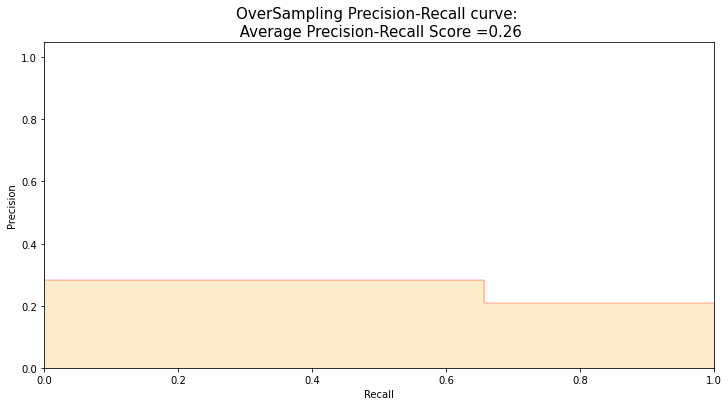

In [ ]:
# Plotting Precision-Recall curve

y_score_reg = best_est_reg.predict(X_val_sm)

average_precision = average_precision_score(y_val_sm, y_score_reg)

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(y_val_sm, y_score_reg)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=15)

plt.show()

# Применение XGBOOST approach

In [ ]:
# List to append the score and then find the average

accuracy_lst_xgb = []
precision_lst_xgb = []
recall_lst_xgb = []
f1_lst_xgb = []
auc_lst_xgb = []

xgb_sm = xgb.XGBClassifier(random_state = 42)
xgb_params = {'eta' : [0.1,0.01,0.001],  # Learning rate
              'eval_metric': ['logloss'],
              'max_depth' : [3,6,9],
              'lambda' : [1,1.5,2],      # L2 regularization (higher values make model more conservative)
              'alpha' : [0,0.5,1]}        # L1 regularization (higher values make model more conservative)
              #'reg' : ['squarederror']}
              #'random_state': [42]}
        
rand_xgb = RandomizedSearchCV(xgb_sm, xgb_params, n_iter=4)


for train, val in sss.split(X_train_sm, y_train_sm):
    pipeline_xgb = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_xgb) 
    model_xgb = pipeline_xgb.fit(X_train_sm, y_train_sm)
    best_est_xgb = rand_xgb.best_estimator_
    prediction_xgb = best_est_xgb.predict(X_train_sm[val])
    
    accuracy_lst_xgb.append(pipeline_xgb.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_xgb.append(precision_score(y_train_sm[val], prediction_xgb))
    recall_lst_xgb.append(recall_score(y_train_sm[val], prediction_xgb))
    f1_lst_xgb.append(f1_score(y_train_sm[val], prediction_xgb))
    auc_lst_xgb.append(roc_auc_score(y_train_sm[val], prediction_xgb))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_xgb)))
print("precision: {}".format(np.mean(precision_lst_xgb)))
print("recall: {}".format(np.mean(recall_lst_xgb)))
print("f1: {}".format(np.mean(f1_lst_xgb)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.8196607142857143
precision: 0.5451868311310736
recall: 0.7814224137931035
f1: 0.6422562294160479
---------------------------------------------------------------------------------------------------------------------------------------


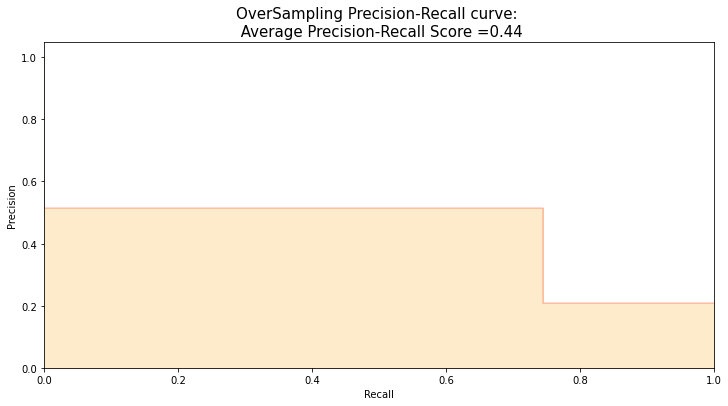

In [ ]:
y_score_xgb = best_est_xgb.predict(X_val_sm)

average_precision_xgb = average_precision_score(y_val_sm, y_score_xgb)

fig = plt.figure(figsize=(12,6))

precision_xgb, recall_xgb, _ = precision_recall_curve(y_val_sm, y_score_xgb)

plt.step(recall_xgb, precision_xgb, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall_xgb, precision_xgb, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision_xgb), fontsize=15)

plt.show()

# Применение RandomForestClassifier

In [ ]:
accuracy_lst_rfc = []
precision_lst_rfc = []
recall_lst_rfc = []
f1_lst_rfc = []
auc_lst_rfc = []

rfc_sm = RandomForestClassifier()
#rfc_params = {}
rfc_params = {'max_features' : ['auto', 'sqrt', 'log2'],
              'random_state' : [42],
              'class_weight' : ['balanced','balanced_subsample'],
              'criterion' : ['gini', 'entropy'],
              'bootstrap' : [True,False]}
    
    
rand_rfc = RandomizedSearchCV(rfc_sm, rfc_params, n_iter=4)


for train, val in sss.split(X_train_sm, y_train_sm):
    pipeline_rfc = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_rfc)
    model_rfc = pipeline_rfc.fit(X_train_sm, y_train_sm)
    best_est_rfc = rand_rfc.best_estimator_
    prediction_rfc = best_est_rfc.predict(X_train_sm[val])
    accuracy_lst_rfc.append(pipeline_rfc.score(X_train_sm[val], y_train_sm[val]))
    recall_lst_rfc.append(recall_score(y_train_sm[val], prediction_rfc))
    f1_lst_rfc.append(f1_score(y_train_sm[val], prediction_rfc))
    

In [ ]:
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_rfc)))
print("precision: {}".format(np.mean(prediction_rfc)))
print("recall: {}".format(np.mean(recall_lst_rfc)))
print("f1: {}".format(np.mean(f1_lst_rfc)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 1.0
precision: 0.20714285714285716
recall: 1.0
f1: 1.0
---------------------------------------------------------------------------------------------------------------------------------------


# Сравнение основных методов оценка эфффективности работы меоделей машинного обучения

In [ ]:
def evaluate_model(accuracy_lst, precision_lst,recall_lst, f1_lst,name):
  accuracy_lst = np.mean(accuracy_lst)
  precision_lst = np.mean(precision_lst)
  recall_lst = np.mean(recall_lst)
  f1_lst = np.mean(f1_lst)
  df = pd.DataFrame([accuracy_lst, precision_lst, recall_lst, f1_lst], index=[f'accuracy_{name}', f'precision_{name}', f'recall_{name}', f'f1_{name}'])
  return df

In [ ]:
df_log = evaluate_model(accuracy_lst_reg, precision_lst_reg,recall_lst_reg, f1_lst_reg, 'logistic regression')
df_xgboost = evaluate_model(accuracy_lst_xgb, precision_lst_xgb,recall_lst_xgb, f1_lst_xgb, 'XGBoost')
df_rf = evaluate_model(accuracy_lst_rfc, precision_lst_rfc,recall_lst_rfc, f1_lst_rfc, 'RandomForestClassifier')
df_all_eval = pd.concat([df_log, df_xgboost, df_rf])
df_all_eval

,0
accuracy_logistic regression,0.584402
precision_logistic regression,0.280432
recall_logistic regression,0.642672
f1_logistic regression,0.390477
accuracy_XGBoost,0.819661
precision_XGBoost,0.545187
recall_XGBoost,0.781422
f1_XGBoost,0.642256
accuracy_RandomForestClassifier,1.000000
precision_RandomForestClassifier,NaN
